Import packages

In [1]:
import scipy.optimize as opt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Example plotting & Basic curve fit

In [2]:
def lorenztian(x, A, sigma, mu):
    return A/np.pi * (sigma/((x-mu)**2+sigma**2))

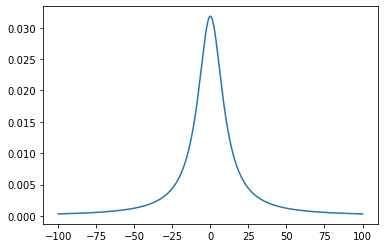

In [3]:
x = np.linspace(-100,100,1000)
y = lorenztian(x, 1, 10, 0)
plt.plot(x,y)

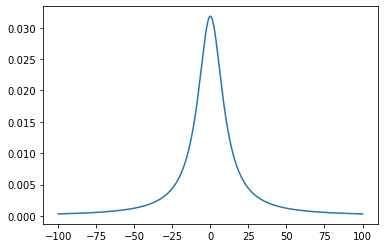

In [4]:
popt, pcov = opt.curve_fit(lorenztian, x, y)
plt.plot(x, lorenztian(x, *popt))

## Example - Double Lorentzian curve fitting
### case. with Non-Setting curve fit

In [5]:
def double_lorenztian(x, a1, s1, m1, a2, s2, m2, y0):
    return lorenztian(x, a1,s1,m1)+lorenztian(x,a2,s2,m2)+y0

In [6]:
file_path = f"./ruby 100K.asc"
df_results = pd.read_csv(file_path,sep="\t",names=['WaveLength', 'Results'],skiprows=40,usecols=range(2),header=None)
display(df_results)

,WaveLength,Results
0,662.72107,484
1,662.77649,487
2,662.83191,487
3,662.88727,485
4,662.94269,487
...,...,...
1005,716.80798,500
1006,716.85999,502
1007,716.91205,499
1008,716.96411,500


Import Data by pandas.read_csv

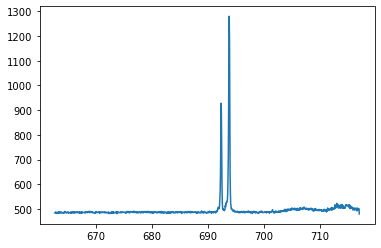

In [7]:
x = df_results.WaveLength.values
y = df_results.Results.values
plt.plot(x,y)

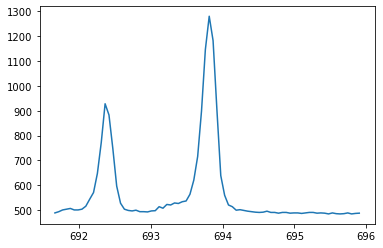

In [8]:
max_idx = np.argmax(y)
view_range = 40
x = x[max_idx-view_range : max_idx+view_range].copy()
y = y[max_idx-view_range : max_idx+view_range].copy()
plt.plot(x,y)

### case. Non-Setting curve Fit

C:\Users\BaeJaeyong\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


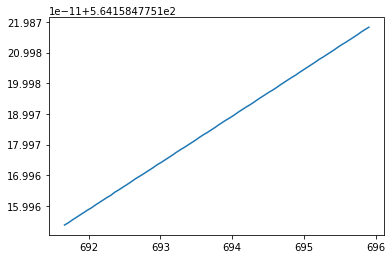

In [9]:
popt, pcov = opt.curve_fit(double_lorenztian, x, y)
plt.plot(x, double_lorenztian(x, *popt))

### case. Initial parameter condition setted curve Fit

In [10]:
import scipy.signal as sig
peaks, _ = sig.find_peaks(y, width=2)

In [11]:
s = np.argsort(y[peaks])
y_pk = y[peaks][s].copy()[::-1].copy()
x_pk = x[peaks][s].copy()[::-1].copy()

p1 = y_pk[0]
p2 = y_pk[1]

x1 = x_pk[0]
x2 = x_pk[1]
    
s1 = 0.05
a1 = p1*np.pi*0.05

s2 = 0.05
a2 = p2*np.pi*0.05

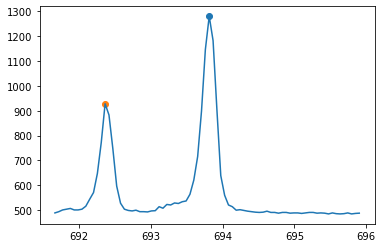

In [12]:
plt.plot(x,y)
plt.scatter(x1,p1)
plt.scatter(x2,p2)

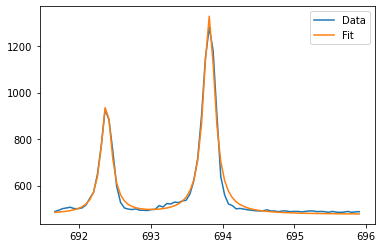

In [13]:
p0=[a1,s1,x1,a2,s2,x2,0]
bounds = (-np.inf, np.inf)

popt, pcov = opt.curve_fit(double_lorenztian, x, y, p0=p0,bounds = bounds)
plt.plot(x,y, label="Data")
plt.plot(x, double_lorenztian(x, *popt), label="Fit")
plt.legend()

### case. Initial parameter condition setted curve Fit (only peak info)

C:\Users\BaeJaeyong\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


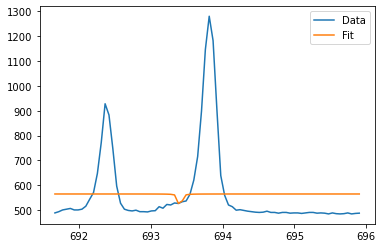

In [14]:
p0=[a1,0,693.5,a2,0,0,692.5]
bounds = (-np.inf, np.inf)

popt, pcov = opt.curve_fit(double_lorenztian, x, y, p0=p0,bounds = bounds)
plt.plot(x,y, label="Data")
plt.plot(x, double_lorenztian(x, *popt), label="Fit")
plt.legend()

### case. Initial parameter condition & detail setting

Further detail setting : https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares  

※ method = "trf" needed for detail setting change

with ftol = 1e-5

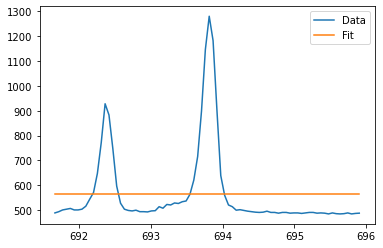

In [15]:
p0=[a1,0,693.5,a2,0,0,692.5]
popt, pcov = opt.curve_fit(double_lorenztian, x, y, p0=p0, method="trf",
                                      ftol=1e-5,
                                      max_nfev=20000, 
                                      x_scale = [1, 0.0001, 0.01, 1, 0.0001, 0.01,1])

plt.plot(x,y, label="Data")
plt.plot(x, double_lorenztian(x, *popt), label="Fit")
plt.legend()

with ftol = 1e-15

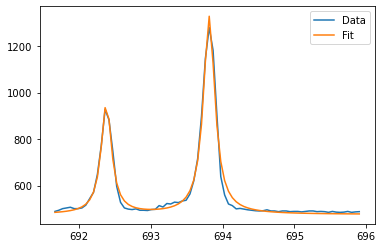

In [16]:
p0=[a1,0,693.5,a2,0,0,692.5]
popt, pcov = opt.curve_fit(double_lorenztian, x, y, p0=p0, method="trf",
                                      ftol=1e-15, xtol=1e-15, gtol=1e-15,
                                      max_nfev=20000, 
                                      x_scale = [1, 0.0001, 0.01, 1, 0.0001, 0.01,1])

plt.plot(x,y, label="Data")
plt.plot(x, double_lorenztian(x, *popt), label="Fit")
plt.legend()

## Example - Interference pattern curve fitting  
with initial condition setting & tolerance, max_nfev, step_size setting

for this example, further package needed

In [17]:
import numba
from scipy.integrate import quad

In [18]:
@numba.jit
def lorenztian(lamb,I,sigma,mu):
    return I*sigma**2/((lamb-mu)**2+sigma**2)

@numba.jit
def func_double_slit(lamb,x,x0,D,b0,h,I,sigma,mu):
    theta = np.arctan2(x-x0,D)
    k = 2*np.pi/lamb
    b = 1/2*k*b0*np.sin(theta)
    if b==0:
        f1 = 1
    else:
        f1 = np.sin(b)/b
    r = 1/2*k*h*np.sin(theta)
    g = lorenztian(lamb,I,sigma,mu)

    return g*(f1)**2*(np.cos(r))**2
def double_intensity_lorentzian(x,I,x0,sigma,mu):
    D = 0.5 #스크린 사이 거리
    int_min = 400*10**(-9)
    int_max = 800*10**(-9)
    res = np.array([quad(func_double_slit,int_min, int_max, args=(x_,x0,D,b,h,I,sigma,mu))[0] for x_ in x])

    return res

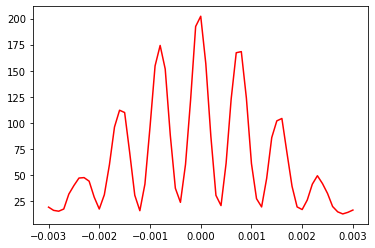

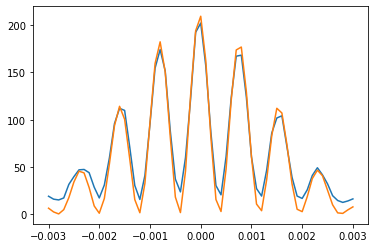

In [19]:
name = "Double 14_5"
df = pd.read_csv(f"./{name}.txt", sep="\t",names=['A', 'B'],usecols=range(2),header=None)

y = df.B.values
x = df.A.values
y = y/10
x = x/1000

x = (x-0.005)
plt.plot(x,y, 'r')
plt.show()

b = 0.085*10**(-3)
h = 0.406*10**(-3)
x0 = 0

I= 10**11
D = 0.5
mu = 550*10**(-9)
sigma = 1*10**(-9)



p0 = [I,x0,sigma,mu]
bounds = ((10**(8),-0.01, 10**(-12), 400*10**(-9)),
          ( 10**(13), 0.01,  10**(-8 ), 800*10**(-9)))
step_size = [10**(6),10**(-6), 10**(-14), 10**(-9)]

popt, pcov = opt.curve_fit(double_intensity_lorentzian, x, y, p0=p0, method="trf",
                        bounds = bounds,
                       ftol=1e-15, xtol=1e-15, gtol=1e-15, max_nfev=5000, 
                       x_scale = step_size )
plt.plot(x,y, label="Data")
plt.plot(x,double_intensity_lorentzian(x, *popt), label="Exp")

※ Trouble Shooting  
ValueError: `x0` is infeasible.  
-> Mostly, inital parameter condition and bounds doesn't match. Out of bounds